In [1]:
_ = '''
    High Dimensional Analysis
    Programming Excercise: 02
    Name: Nguyễn Phú Thành
    Student Code: 18110014
'''

## PROBLEM:
## Apply Linear Discriminant Analysis algorithm on the Iris flower dataset. Make a comparison between LDA and PCA projected samples.
## Note: Do LDA step by step, available tool for PCA is accepted.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

In [3]:
col_names = ['sepal length', 'sepal width', 'petal length', 'petal width', 'class']
data = pd.read_csv('iris.data', names = col_names)

In [4]:
data.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
listClasses = data['class'].unique()
mapper = {val: i for (i, val) in enumerate(listClasses)}
demapper = {value: key for (key, value) in mapper.items()}

In [6]:
mapper

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

In [7]:
demapper

{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}

In [8]:
data['class'] = data['class'].apply(lambda val: mapper[val])

In [9]:
data.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [10]:
def standardizeData(X):
    '''
        Standarize array X of dimension n x k 
        where n is a number of samples and d is a number of dimensions, 
        therefore each row in X is an observation of r.v in d dimensions
    '''
    mean, std = np.mean(X, axis = 0), np.std(X, axis = 0, ddof = 1)
    return (X - mean)/std

In [11]:
class LDA:
    
    def __init__(self, n_combonents = None):
        '''
            Initialize LDA object
            Parameters:
                n_combonents: int, default None
                    Number of combonents to get after apply LDA
                    If None, all of combonents will return
        '''
        self.n_combonents = n_combonents
        self.W = None
    
    def betweenClassAndWithinClass_(self, X, y):
        '''
            Calculate Between-class and Within-class scatter matrices
            (formulas for these two matrices are in file report)
        '''
        S_W, S_B = 0, 0
        overall_mean = np.mean(X, axis = 0).reshape(-1, 1)
        for id_class in np.unique(y):
            subset_X = X[y == id_class].copy()
            mean_vec = np.mean(subset_X, axis = 0).reshape(-1, 1)
            S_i = 0
            for sample in subset_X:
                sample = sample.reshape(-1, 1)
                S_i += (sample - mean_vec) @ (sample - mean_vec).T
            S_W += S_i
            S_B += subset_X.shape[0] * (mean_vec - overall_mean) @ (mean_vec - overall_mean).T
        return S_B, S_W
    
    def fit(self, X, y):
        '''
            Calculate projection matrix W where each column is a eigenvector of S_W^{-1}S_B
            Parameters:
                X: ndarray of shape (n_samples, d_features)
                    Data matrix
                y: ndarray of shape (n_samples,)
                    An array of labels for each sample (observation) in X
        '''
        self.betweenClassMat, self.withinClassMat = self.betweenClassAndWithinClass_(X, y)
        eigenvals, eigenvecs = np.linalg.eig(np.linalg.inv(self.withinClassMat) @ self.betweenClassMat)
        eigenpairs = [
            (eigenval, eigenvec.reshape(-1, 1)) for (eigenval, eigenvec) in zip(eigenvals, eigenvecs.T)
        ]
        eigenpairs = sorted(eigenpairs, key = lambda pair: pair[0], reverse = True)
        eigenvecs = [eigenvec for (_, eigenvec) in eigenpairs]
        if self.n_combonents is None:
            self.W = np.hstack(eigenvecs)
        else:
            self.W = np.hstack(eigenvecs[:self.n_combonents])
        return self
    
    def transform(self, X):
        '''
            Apply transformation by project X onto W
            Parameters:
                X: ndarray of shape (n_samples, d_features)
                    Data matrix to be projected onto W
        '''
        assert self.W is not None, 'LDA object must fit to data first before perform transformation'
        return X @ self.W
    
    def fit_transform(self, X, y):
        '''
            Fit and transform in one-go
            Parameters:
                X: ndarray of shape (n_samples, d_features)
                    Data matrix
                y: ndarray of shape (n_samples,)
                    An array of labels for each sample (observation) in X
        '''
        self.betweenClassMat, self.withinClassMat = self.betweenClassAndWithinClass_(X, y)
        eigenvals, eigenvecs = np.linalg.eig(np.linalg.inv(self.withinClassMat) @ self.betweenClassMat)
        eigenpairs = [
            (eigenval, eigenvec.reshape(-1, 1)) for (eigenval, eigenvec) in zip(eigenvals, eigenvecs.T)
        ]
        eigenpairs = sorted(eigenpairs, key = lambda pair: pair[0], reverse = True)
        eigenvecs = [eigenvec for (_, eigenvec) in eigenpairs]
        if self.n_combonents is None:
            self.W = np.hstack(eigenvecs)
        else:
            self.W = np.hstack(eigenvecs[:self.n_combonents])
        
        return X @ self.W

In [12]:
X, y = data.iloc[:, :-1].to_numpy(), data.iloc[:, -1].to_numpy()
X = standardizeData(X)

In [13]:
lda = LDA(n_combonents = 2)

In [14]:
X_transform_lda = lda.fit_transform(X, y)

In [15]:
pca = PCA(n_components = 2).fit(X)

In [16]:
X_transform_pca = pca.transform(X)

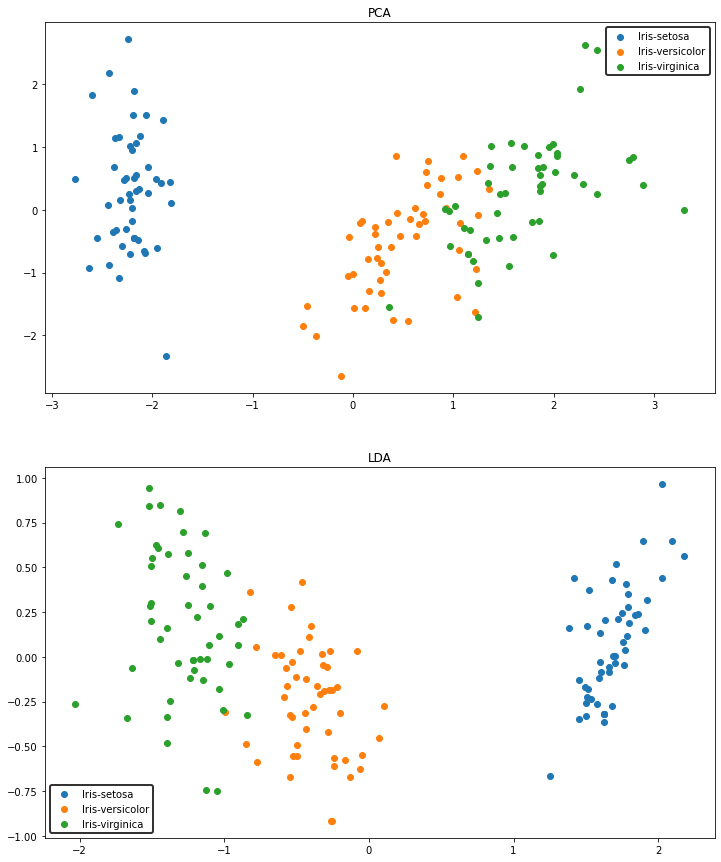

In [17]:
fig, axes = plt.subplots(figsize = (12, 15), nrows = 2, ncols = 1)

for (i, (X_transform, name)) in enumerate(zip([X_transform_pca, X_transform_lda], ['PCA', 'LDA'])):
    for id_class in np.unique(y):
        subset_X = X_transform[y == id_class]
        axes[i].scatter(subset_X[:, 0], subset_X[:, 1], label = demapper[id_class])
    axes[i].set(title = name)
    legend = axes[i].legend()
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_edgecolor('black')
fig.savefig('LDA_vs_PCA.jpg')